# Сети с обратными связями

**Цель работы:** исследование свойств сетей Хопфилда, Хэмминга и Элмана, алгоритмов обучения, а также применение сетей в задачах распознавания статических и динамических
образов.

| <!-- --> | <!-- --> |
|:---------|:---------|
| Студент    | Почечура А. А.   |
| Группа   | М8О-406Б-20  |
| Вариант    | 18   |

Подключаем библиотеки, которые нам понадобятся в данной работе

In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm
from sklearn.model_selection import train_test_split

Сгенерируем датасет обущеющего множества соответственно варианту задания. Отобразим полученные данные на графике.

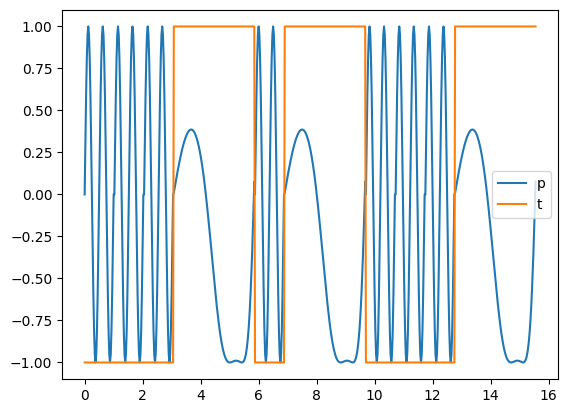

In [221]:
h = 0.025
k1 = torch.arange(0, 1+h, h)
p1 = torch.sin(4*torch.pi*k1)
t1 = -torch.ones_like(k1)

k2 = torch.arange(0.01, 2.77+h, h)
p2 = torch.sin(-torch.sin(k2)*k2**2+k2)
t2 = torch.ones_like(k2)

R = [3,1,3]

p = torch.cat((torch.tile(p1, (R[0],)), p2, torch.tile(p1, (R[1],)), p2, torch.tile(p1, (R[2],)), p2), 0)
t = torch.cat((torch.tile(t1, (R[0],)), t2, torch.tile(t1, (R[1],)), t2, torch.tile(t1, (R[2],)), t2), 0)
x = torch.arange(p.shape[0]) * h
plt.plot(x, p, label='p')
plt.plot(x, t, label='t')
plt.legend()
plt.show()

Зададим *x_train* и *y_train* с помощью метода "скользящего окна" размера *D = 5*.

In [222]:
def data(x, y, D):
  x_train = torch.zeros((x.shape[0]-D, D))
  y_train = torch.zeros((y.shape[0]-D, D))
  for i in range(0, x.shape[0]-D):
    x_train[i] = x[i:i+D]
    y_train[i] = y[i:i+D]
  return x_train, y_train

D = 5
x_train, y_train = data(p, t, D)

Задаём параметры линейного слоя

In [223]:
class Linear(nn.Module):
  def __init__(self, inputs, outputs):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(inputs, outputs))
    self.bias = nn.Parameter(torch.randn(outputs))

  def forward(self, x):
    x = x @ self.weights + self.bias
    return x

Создадим класс Elman, с помощью которого опишем наш слой для сети Элмана. Здесь используется принцип рекурентных нейронных сетей, согласно которому мы прогоняем наши данные через нейроны несколько раз, учитывая предыдущие результаты.

In [237]:
Tanh = nn.Tanh()
class Elman(nn.Module):
    def __init__(self, inputs, hidden):
        super().__init__()
        self.weights_w = nn.Parameter(torch.randn(inputs, hidden))
        self.weights_u = nn.Parameter(torch.randn(hidden, hidden))
        self.bias = nn.Parameter(torch.randn(hidden))
        self.hidden = hidden
        self.pred = torch.zeros((self.hidden)).requires_grad_()

    def forward(self, x):
        hiddens = []
        hidden_t = self.pred
        for i in range(x.shape[0]):
          hidden_t = Tanh(x[i] @ self.weights_w + hidden_t @ self.weights_u + self.bias)
          hiddens.append(hidden_t)
        self.pred = hidden_t.detach()
        hiddens = torch.stack(hiddens)
        return hiddens

Класс ElmanN описывает нашу сеть, состояющую из двух слоёв, целиком

In [238]:
Tanh = nn.Tanh()
class ElmanN(nn.Module):
    def __init__(self, inputs, hidden, outputs):
        super().__init__()
        self.hidden = Elman(inputs, hidden)
        self.output = Linear(hidden, outputs)

    def forward(self, x):
        x = self.hidden(x)
        x = Tanh(self.output(x))
        return x

Далее идёт класс Trainer, с помощью которого мы тренируем нашу сеть. Иницализируем класс параметрами обучения и определяем порядок обучения.

In [239]:
class Trainer():
  def __init__(self,  net, loss_f, learning_rate=1e-3,
              epoch_amount=10,
              optim=torch.optim.Adam):

    self.loss_f = loss_f
    self.learning_rate = learning_rate
    self.epoch_amount = epoch_amount
    self.optim = optim
    self.model = net

    self.train_loss = []

  def predict(self, X):
    with torch.no_grad():
      return self.model(X)

  def fit(self, x_train, y_train):
    Net = self.model
    optimizer = self.optim(Net.parameters(), lr=self.learning_rate)

    with tqdm(desc="epoch", total=self.epoch_amount) as bar:
      for epoch in range(self.epoch_amount):
        optimizer.zero_grad()
        predicted_values = Net(x_train)
        loss1 = self.loss_f(predicted_values, y_train)
        loss1.backward()
        optimizer.step()

        self.train_loss.append(loss1.detach().numpy())

        bar.set_postfix({"Loss_train": loss1.detach().numpy()})
        bar.update()

Производим обучение модели. Количество нейронов в сети равно 8.

In [236]:
net = ElmanN(D,8,D)
train = Trainer(net, nn.MSELoss(), 0.1, 100, torch.optim.Adam)
train.fit(x_train, y_train)

epoch: 100%|██████████| 100/100 [00:13<00:00,  7.42it/s, Loss_train=0.058635782]


Отобразим на графике значения ошибок, полученных в процессе обучения модели.

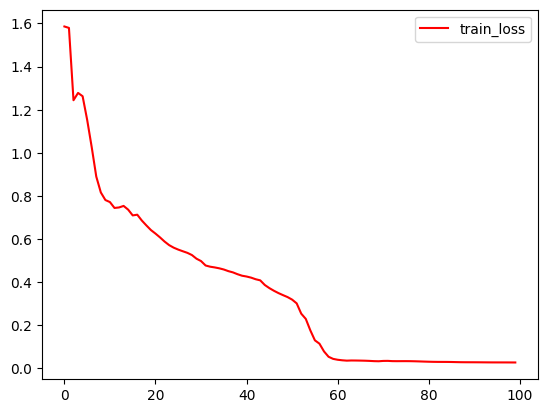

In [134]:
plt.plot(train.train_loss, "red", label='train_loss')
plt.legend()
plt.show()

Проиллюстрируем на графике полученные предсказанные значения в сравнении с реальными:

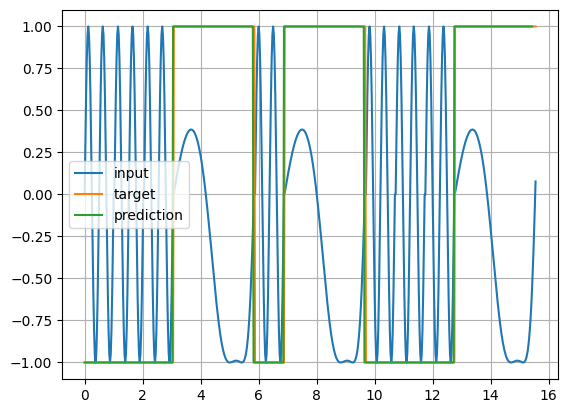

In [140]:
preds = np.sign(train.predict(x_train))
plt.plot(x, p, label='input')
plt.plot(x, t, label='target')
plt.plot(x[:-D], preds[:,1], label='prediction')

plt.grid()
plt.legend()
plt.show()

**Вывод**: В процессе выполнения данной лабораторной работы я научился самостоятельно реализовывать и практически применять рекурентные нейронные сети, в частности сеть Элмана. Интересно было разбираться в тонкостях реализации данной сети. Принцип обучения в рекурентных сетях немного отличается от обучения других сетей, что позволяет их использовать для решения нестандартных задач (например: анализ текстов).